In [61]:
import re
import os
import sys
import string
from collections import Counter
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


from get_data import get_data
from Constants import Constants

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
print("TensorFlow is using GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow is using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
data = get_data(Constants.social_media_dataset_path, encoding="iso-8859-9 ")

In [7]:
data.tail()

,Tip,Paylaşım
11114,Pozitif,bugün hava güzel
11115,Pozitif,allah akıl fikir versin
11116,Negatif,allah belanı versin
11117,Pozitif,allah akıl fikir versin sana
11118,Pozitif,allah akıl fikir versin


In [8]:
data.Tip.value_counts()

Pozitif    6115
Negatif    5004
Name: Tip, dtype: int64

In [9]:
data.isnull().sum()

Tip         0
Paylaşım    2
dtype: int64

In [10]:
data = data.dropna()
data.isnull().sum()

Tip         0
Paylaşım    0
dtype: int64

In [11]:
data.describe(include='all')

,Tip,Paylaşım
count,11117,11117
unique,2,11005
top,Pozitif,allah belanı versin
freq,6113,3


In [12]:
data = data.rename(columns={"Paylaşım": "text", "Tip": "label"})

In [13]:
unique_values = data['text'].value_counts()
non_unique_values = unique_values[unique_values > 1].index
filtered_df = data[~data['text'].isin(non_unique_values)]

In [14]:
filtered_df.describe(include='all')

,label,text
count,10899,10899
unique,2,10899
top,Pozitif,doğa ağzımıza sıçsa hakkı var
freq,6019,1


In [15]:
data = filtered_df

In [16]:
data.label.unique()

array(['Negatif', 'Pozitif'], dtype=object)

In [17]:
data['words'] = [len(x.split()) for x in data['text'].tolist()]
data[['words','text']].head()

,words,text
0,5,doğa ağzımıza sıçsa hakkı var
1,6,anne bir sanatçıdır güzel eseri yavrusudur
2,6,ibrahimin oğlunu koruyan tanrı ben sokayım
3,6,köpeğim suratına sıçsın senin namussuz karı
4,5,ben söğüşledim birazda sen söğüşle


In [18]:
data['words'].describe()

count    10899.000000
mean        10.139462
std          7.314577
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max         61.000000
Name: words, dtype: float64

In [19]:
len(data)

10899

In [22]:
len(data.query('words > 30'))

340

In [23]:
data.query('words < 3').head(20)

,label,text,words
28,Negatif,öldürür,1
63,Negatif,siksokçular anlık,2
103,Negatif,utanmazlar,1
111,Negatif,aq midesizsiniz,2
137,Pozitif,mutlu oldum,2
141,Pozitif,seviyorum,1
143,Pozitif,satılık herif,2
148,Negatif,kaltak tutuklansın,2
156,Negatif,pis suratsız,2
165,Negatif,hayvan katili,2


In [24]:
len(data.query('words > 25'))

627

In [25]:
data.groupby(['label'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Negatif,4880.0,9.575205,7.256583,1.0,4.0,7.0,13.0,44.0
Pozitif,6019.0,10.596943,7.330042,1.0,5.0,9.0,14.0,61.0


In [26]:
max_text_size = 30

In [27]:
data = data[data['words'] <= max_text_size]

In [28]:
data = data.reset_index(drop=True)

In [29]:
data.count()

label    10559
text     10559
words    10559
dtype: int64

In [30]:
word_freq= data.text.str.split(expand=True).stack().value_counts()
word_freq=word_freq.reset_index(name='freq').rename(columns={'index': 'word'})
top_20_frequent_words = word_freq[:20]
top_20_frequent_words

,word,freq
0,bir,1762
1,ben,522
2,kadar,503
3,var,480
4,sen,443
5,bi,422
6,senin,395
7,seni,360
8,yok,350
9,mi,326


# PREPARE THE DATASET

## Custom Standardization

In [31]:
tr_stopwords = get_data(Constants.tr_stopwords_path, header=None)

In [32]:
def custom_standardization(input_string):
    """Remove HTML line-break tags, handle punctuation, remove stopwords, and normalize text."""
    # Lowercase the text
    no_uppercased = input_string.lower()
    
    # Replace asterisks with space
    no_stars = re.sub(r"\*", " ", no_uppercased)
    
    # Remove HTML tags
    no_html = re.sub(r"<br\s*/?>", "", no_stars)
    
    # Remove words containing digits
    no_digits = re.sub(r"\w*\d\w*", "", no_html)
    
    # Remove punctuations
    no_punctuations = re.sub(f"[{re.escape(string.punctuation)}]", " ", no_digits)
    
    # Remove extra spaces
    no_extra_space = re.sub(r"\s+", " ", no_punctuations).strip()
    
    # Normalize Turkish characters
    no_I = no_extra_space.replace("ı", "i")
    no_O = no_I.replace("ö", "o")
    no_C = no_O.replace("ç", "c")
    no_S = no_C.replace("ş", "s")
    no_G = no_S.replace("ğ", "g")
    no_U = no_G.replace("ü", "u")
    
    # Remove stopwords using regex
    no_stop_words = no_U
    for stopword in tr_stopwords[0]:
        no_stop_words = re.sub(rf"\b{stopword}\b", "", no_stop_words)
    
    # Remove any extra spaces again after removing stopwords
    cleaned_text = re.sub(r"\s+", " ", no_stop_words).strip()
    
    return cleaned_text

In [33]:
data["text"] = data["text"].apply(custom_standardization)

In [34]:
data.tail()

,label,text,words
10554,Negatif,surata bak lenetlenmis oc,4
10555,Negatif,allah in din tcarlari sizi insana iftira atman...,23
10556,Negatif,aptal oc,2
10557,Negatif,asalak,1
10558,Pozitif,bugun hava guzel,3


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10559 entries, 0 to 10558
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10559 non-null  object
 1   text    10559 non-null  object
 2   words   10559 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 247.6+ KB


In [37]:
data.describe()

,words
count,10559.000000
mean,9.368974
std,5.991126
min,1.000000
25%,5.000000
50%,8.000000
75%,13.000000
max,30.000000


In [38]:
data = data.sample(frac=1)

In [39]:
data["label"] = data["label"].astype('category')
data.dtypes

label    category
text       object
words       int64
dtype: object

In [40]:
data["LabelId"] = data["label"].cat.codes

In [42]:
data.head(1)

,label,text,words,LabelId
10074,Negatif,merlin mal artur iyi,4,0


In [43]:
data.dtypes

label      category
text         object
words         int64
LabelId        int8
dtype: object

In [44]:
id_to_label = pd.Series(data.label.values,index=data.LabelId).to_dict()
id_to_label

{0: 'Negatif', 1: 'Pozitif'}

In [ ]:
label_to_id = {v:k for k,v in id_to_label.items()}
label_to_id

{'Negatif': 0, 'Pozitif': 1}

In [46]:
import pickle
with open('id_to_label_data2.pkl', 'wb') as fp:
    pickle.dump(id_to_label, fp)

In [47]:
with open('label_to_id_data2.pkl', 'wb') as fp:
    pickle.dump(label_to_id, fp)

## Split Dataset

In [48]:
texts = data['text']  # Metinlerin olduğu sütun
labels = data['LabelId']  # Etiketlerin olduğu sütun

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, 
    test_size=0.2, 
    random_state=42,
    shuffle = True,
    stratify=labels
)

In [49]:
print("Train Data Set size: ",len(train_texts))
print("Test Data Set size: ",len(test_texts))

Train Data Set size:  8447
Test Data Set size:  2112


# Embeddings

In [50]:
def get_embeddings(model_name, texts, batch_size=32):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModel.from_pretrained(model_name, trust_remote_code=True)  # trust_remote_code parametresi eklendi
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        tokens = tokenizer(batch, padding=True, truncation=True, return_tensors="tf")
        outputs = model(**tokens)
        # Pooling işlemi (örnek olarak mean pooling kullanıyoruz)
        embeddings.append(tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy())
    
    return np.vstack(embeddings)


In [51]:
models = [
    "dbmdz/bert-base-turkish-uncased",
    "sentence-transformers/all-MiniLM-L12-v2",
    "intfloat/multilingual-e5-large-instruct",
    "dbmdz/electra-base-turkish-cased-discriminator",
    "cardiffnlp/twitter-xlm-roberta-base"
]

train_embeddings = {}
test_embeddings = {}

for model_name in models:
    print(f"Processing model: {model_name}")
    train_embeddings[model_name] = get_embeddings(model_name, train_texts.tolist())
    test_embeddings[model_name] = get_embeddings(model_name, test_texts.tolist())


Processing model: dbmdz/bert-base-turkish-uncased


Some layers from the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 264/264 [00:19<00:00, 13.59it/s]
Some layers from the model checkpoint at dbmdz/bert-base-turkish-uncased were not use

Processing model: sentence-transformers/all-MiniLM-L12-v2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 264/264 [00:18<00:00, 14.20it/s]
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are 

Processing model: intfloat/multilingual-e5-large-instruct


All PyTorch model weights were used when initializing TFXLMRobertaModel.

All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
100%|██████████| 264/264 [00:36<00:00,  7.29it/s]
All PyTorch model weights were used when initializing TFXLMRobertaModel.

All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
100%|██████████| 66/66 [00:09<00:00,  7.16it/s]


Processing model: dbmdz/electra-base-turkish-cased-discriminator


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.
100%|██████████| 264/264 [00:1

Processing model: cardiffnlp/twitter-xlm-roberta-base


All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
100%|██████████| 264/264 [00:18<00:00, 14.59it/s]
All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
100%|██████████| 66/66 [00:04<00:00, 14.58it/s]


# Model

In [52]:
# Sınıflandırıcılar
classifiers = {
    "SVM": SVC,
    "RandomForest": RandomForestClassifier,
    "MLP": MLPClassifier
}

# Eğitimli modelleri saklamak için
trained_classifiers = {model_name: {} for model_name in train_embeddings.keys()}
all_predictions = {model_name: {} for model_name in train_embeddings.keys()}

# Eğitim ve sonuçları toplama
results = []
for model_name, train_embed in train_embeddings.items():
    for clf_name, clf_class in classifiers.items():
        print(f"Training {clf_name} with {model_name}")
        
        # Her döngüde yeni bir sınıflandırıcı oluştur ve eğit
        clf = clf_class()
        clf.fit(train_embed, train_labels)
        
        # Eğitimli modeli ve tahminlerini sakla
        trained_classifiers[model_name][clf_name] = clf
        predictions = clf.predict(test_embeddings[model_name])
        all_predictions[model_name][clf_name] = predictions
        
        # Metriği hesapla ve kaydet
        acc = accuracy_score(test_labels, predictions)
        f1 = f1_score(test_labels, predictions, average="weighted")
        
        results.append({
            "Representation": model_name,
            "Classifier": clf_name,
            "Accuracy": acc,
            "F1-Score": f1
        })

results_df = pd.DataFrame(results)


Training SVM with dbmdz/bert-base-turkish-uncased
Training RandomForest with dbmdz/bert-base-turkish-uncased
Training MLP with dbmdz/bert-base-turkish-uncased
Training SVM with sentence-transformers/all-MiniLM-L12-v2
Training RandomForest with sentence-transformers/all-MiniLM-L12-v2
Training MLP with sentence-transformers/all-MiniLM-L12-v2
Training SVM with intfloat/multilingual-e5-large-instruct
Training RandomForest with intfloat/multilingual-e5-large-instruct
Training MLP with intfloat/multilingual-e5-large-instruct


c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\odev_1\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training SVM with dbmdz/electra-base-turkish-cased-discriminator
Training RandomForest with dbmdz/electra-base-turkish-cased-discriminator
Training MLP with dbmdz/electra-base-turkish-cased-discriminator


c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\odev_1\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training SVM with cardiffnlp/twitter-xlm-roberta-base
Training RandomForest with cardiffnlp/twitter-xlm-roberta-base
Training MLP with cardiffnlp/twitter-xlm-roberta-base


c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\odev_1\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
results_df

,Representation,Classifier,Accuracy,F1-Score
0,dbmdz/bert-base-turkish-uncased,SVM,0.849432,0.849078
1,dbmdz/bert-base-turkish-uncased,RandomForest,0.830492,0.829353
2,dbmdz/bert-base-turkish-uncased,MLP,0.841383,0.841104
3,sentence-transformers/all-MiniLM-L12-v2,SVM,0.737216,0.732051
4,sentence-transformers/all-MiniLM-L12-v2,RandomForest,0.670928,0.662914
5,sentence-transformers/all-MiniLM-L12-v2,MLP,0.731534,0.730231
6,intfloat/multilingual-e5-large-instruct,SVM,0.816288,0.815502
7,intfloat/multilingual-e5-large-instruct,RandomForest,0.761364,0.757648
8,intfloat/multilingual-e5-large-instruct,MLP,0.792614,0.792289
9,dbmdz/electra-base-turkish-cased-discriminator,SVM,0.786458,0.784578


In [54]:
results_df.groupby("Representation")[["F1-Score"]].mean()

,F1-Score
Representation,
cardiffnlp/twitter-xlm-roberta-base,0.791038
dbmdz/bert-base-turkish-uncased,0.839845
dbmdz/electra-base-turkish-cased-discriminator,0.779576
intfloat/multilingual-e5-large-instruct,0.788480
sentence-transformers/all-MiniLM-L12-v2,0.708399


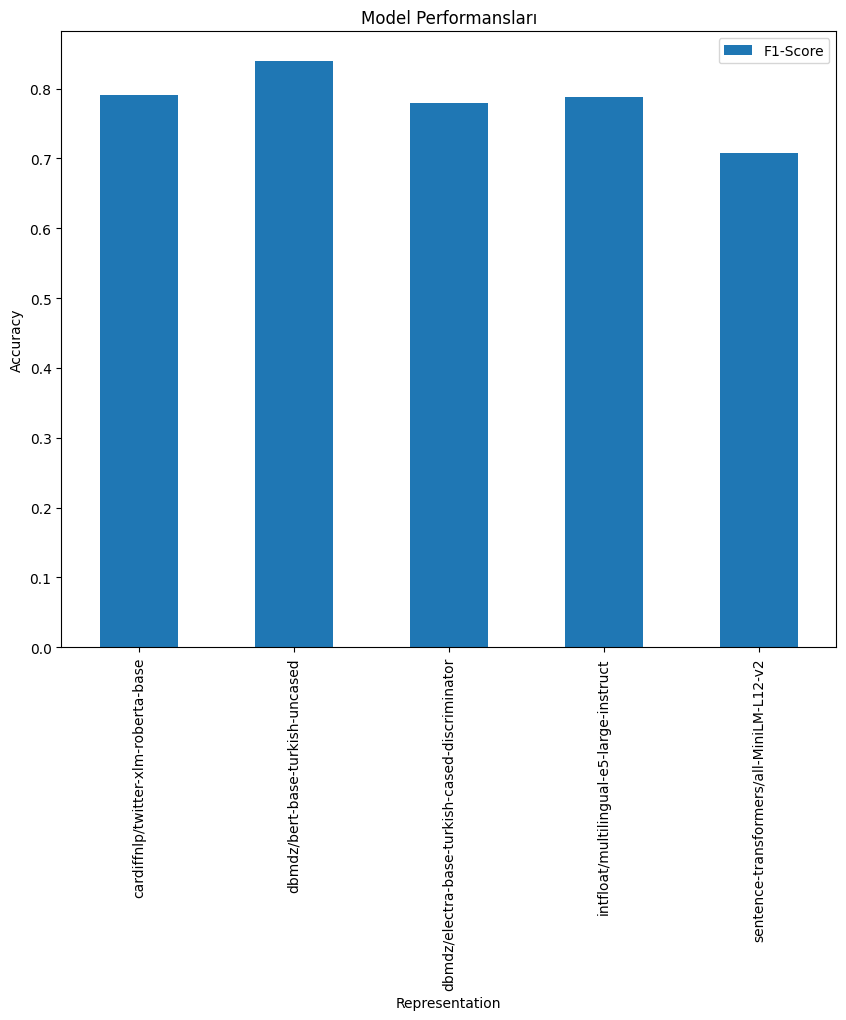

In [55]:
results_df.groupby("Representation")[["F1-Score"]].mean().plot(kind="bar", figsize=(10, 8))
plt.title("Model Performansları")
plt.ylabel("Accuracy")
plt.show()

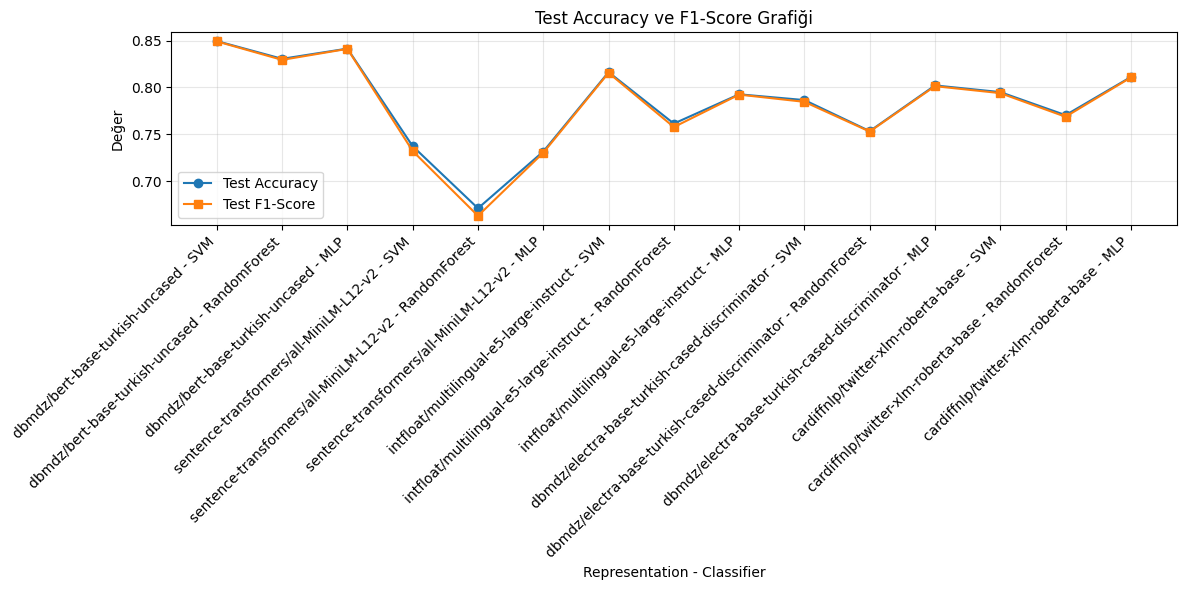

In [56]:
# Test Accuracy ve F1-Score değerlerini çizgi grafiğiyle görselleştirme
plt.figure(figsize=(12, 6))

# Test Accuracy çizgisi
plt.plot(
    results_df["Representation"] + " - " + results_df["Classifier"],  # Model ve sınıflandırıcı isimleri
    results_df["Accuracy"],
    marker='o',
    label="Test Accuracy"
)

# Test F1-Score çizgisi
plt.plot(
    results_df["Representation"] + " - " + results_df["Classifier"],
    results_df["F1-Score"],
    marker='s',
    label="Test F1-Score"
)

# Grafik detayları
plt.xticks(rotation=45, ha='right')  # X eksenindeki model isimlerini döndürme
plt.title("Test Accuracy ve F1-Score Grafiği")
plt.xlabel("Representation - Classifier")
plt.ylabel("Değer")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Grafiği gösterme
plt.show()

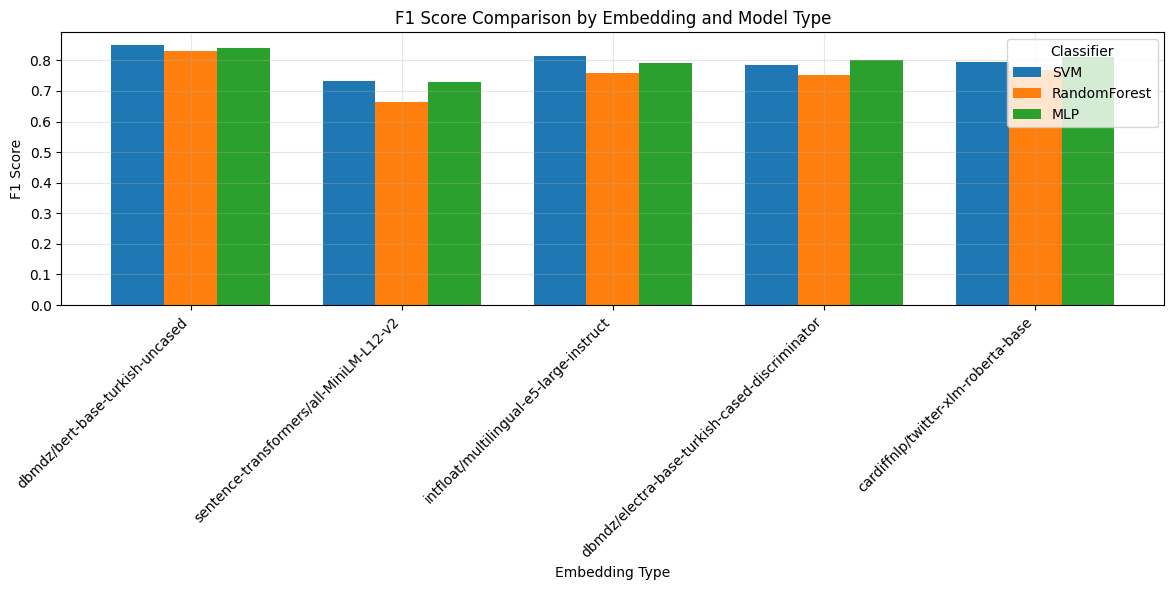

In [57]:
# Verileri hazırlama
embedding_types = results_df["Representation"].unique()  # Embedding türleri
unique_classifiers = results_df["Classifier"].unique()  # Sınıflandırıcı türleri

# Gruplar bazında F1 skorlarını hesaplama
f1_scores = []
for embedding in embedding_types:
    scores = []
    for clf in unique_classifiers:
        # Her embedding ve sınıflandırıcı kombinasyonu için F1 skorunu al
        score = results_df[
            (results_df["Representation"] == embedding) & (results_df["Classifier"] == clf)
        ]["F1-Score"].values[0]
        scores.append(score)
    f1_scores.append(scores)

f1_scores = np.array(f1_scores)  # Listeyi numpy dizisine çevir

# Bar grafiği için gerekli ayarlar
x = np.arange(len(embedding_types))  # Embedding türleri için x ekseni pozisyonları
bar_width = 0.25  # Bar genişliği

# Grafik çizimi
fig, ax = plt.subplots(figsize=(12, 6))

for i, clf in enumerate(unique_classifiers):
    ax.bar(
        x + i * bar_width,
        f1_scores[:, i],
        width=bar_width,
        label=clf
    )

# X ekseni ve başlıklar
ax.set_xticks(x + bar_width)
ax.set_xticklabels(embedding_types, rotation=45, ha='right')
ax.set_title("F1 Score Comparison by Embedding and Model Type")
ax.set_xlabel("Embedding Type")
ax.set_ylabel("F1 Score")
ax.legend(title="Classifier")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

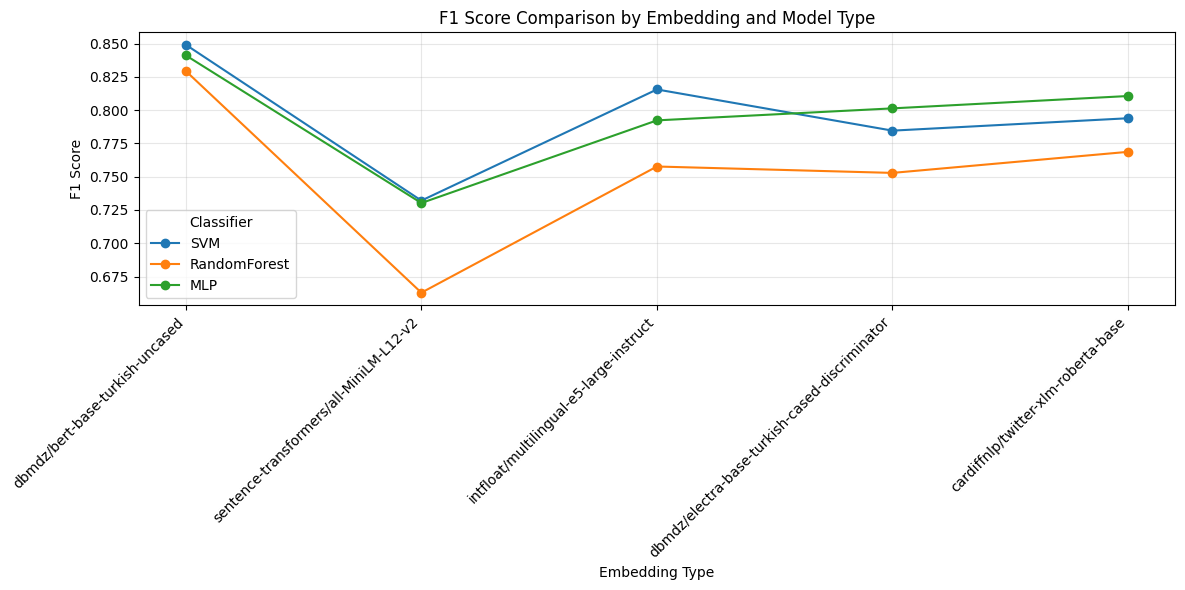

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))

# Her sınıflandırıcı için F1 skorları
for i, clf in enumerate(unique_classifiers):
    ax.plot(
        embedding_types,
        f1_scores[:, i],
        marker='o',
        label=clf
    )

ax.set_xticks(range(len(embedding_types)))
ax.set_xticklabels(embedding_types, rotation=45, ha='right')

# Başlık ve etiketler
ax.set_title("F1 Score Comparison by Embedding and Model Type")
ax.set_xlabel("Embedding Type")
ax.set_ylabel("F1 Score")
ax.legend(title="Classifier")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [59]:
classifiers

{'SVM': sklearn.svm._classes.SVC,
 'RandomForest': sklearn.ensemble._forest.RandomForestClassifier,
 'MLP': sklearn.neural_network._multilayer_perceptron.MLPClassifier}

# Aynı Temsil Yöntemi İçin Ensemble

In [62]:
def majority_voting(predictions_list):
    final_predictions = []
    for preds in zip(*predictions_list):
        most_common = Counter(preds).most_common(1)[0][0]
        final_predictions.append(most_common)
    return final_predictions

same_representation_ensembles = {}
for model_name, preds_dict in all_predictions.items():
    predictions_list = list(preds_dict.values())  # SVM, RF, MLP preds
    ensemble_predictions = majority_voting(predictions_list)
    same_representation_ensembles[model_name] = ensemble_predictions

# Aynı Algoritma İçin Ensemble

In [63]:
same_algorithm_ensembles = {}
for clf_name in classifiers.keys():
    predictions_list = [all_predictions[model_name][clf_name] for model_name in train_embeddings.keys()]
    ensemble_predictions = majority_voting(predictions_list)
    same_algorithm_ensembles[clf_name] = ensemble_predictions

# Tüm Sonuçları Birleştirerek Ensemble

In [64]:
all_predictions_list = [
    all_predictions[model_name][clf_name]
    for model_name in train_embeddings.keys()
    for clf_name in classifiers.keys()
]
final_ensemble_predictions = majority_voting(all_predictions_list)

# Sonuçları Karşılaştırma

In [65]:
comparison_results = []

# Temsil bazlı ensemble
for model_name, predictions in same_representation_ensembles.items():
    acc = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average="weighted")
    comparison_results.append({
        "Ensemble_Type": "Representation-Based",
        "Group": model_name,
        "Accuracy": acc,
        "F1-Score": f1
    })

# Algoritma bazlı ensemble
for clf_name, predictions in same_algorithm_ensembles.items():
    acc = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average="weighted")
    comparison_results.append({
        "Ensemble_Type": "Algorithm-Based",
        "Group": clf_name,
        "Accuracy": acc,
        "F1-Score": f1
    })

# Tüm modellerin ensemble ı
acc = accuracy_score(test_labels, final_ensemble_predictions)
f1 = f1_score(test_labels, final_ensemble_predictions, average="weighted")
comparison_results.append({
    "Ensemble_Type": "All-Models",
    "Group": "All",
    "Accuracy": acc,
    "F1-Score": f1
})

# Sonuçları birleştirme
comparison_df = pd.DataFrame(comparison_results)
comparison_df

,Ensemble_Type,Group,Accuracy,F1-Score
0,Representation-Based,dbmdz/bert-base-turkish-uncased,0.850379,0.849855
1,Representation-Based,sentence-transformers/all-MiniLM-L12-v2,0.739583,0.734882
2,Representation-Based,intfloat/multilingual-e5-large-instruct,0.812500,0.811542
3,Representation-Based,dbmdz/electra-base-turkish-cased-discriminator,0.795455,0.794041
4,Representation-Based,cardiffnlp/twitter-xlm-roberta-base,0.801136,0.799910
5,Algorithm-Based,SVM,0.830966,0.829513
6,Algorithm-Based,RandomForest,0.815341,0.812612
7,Algorithm-Based,MLP,0.853220,0.852470
8,All-Models,All,0.847064,0.845812


# Sonucu Görselleştirme

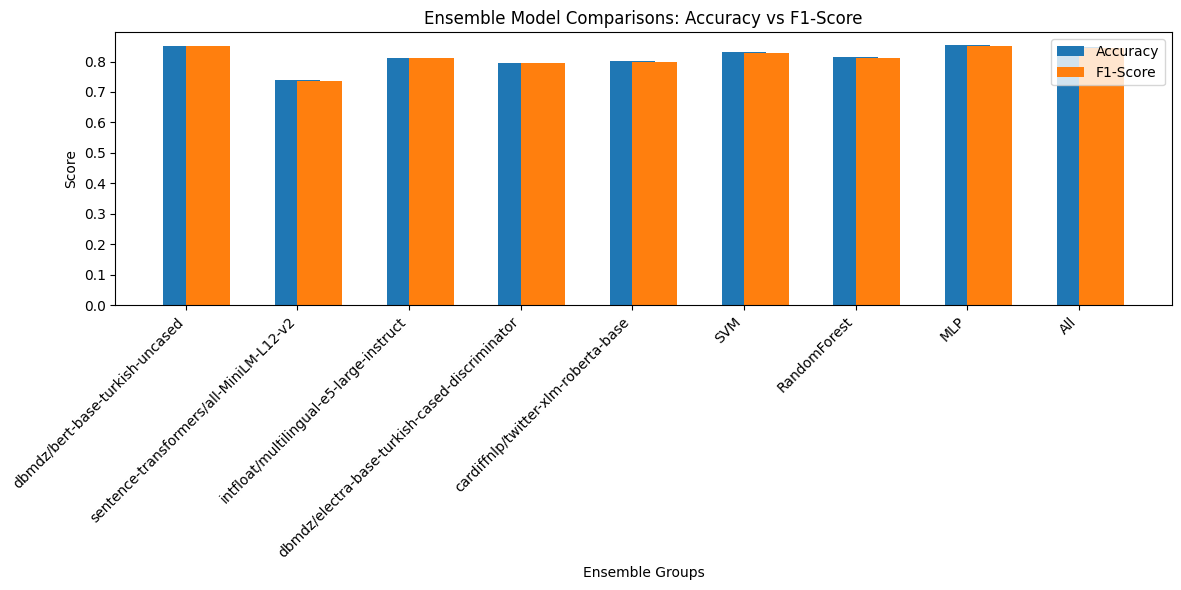

In [66]:
# Bar plot: Accuracy ve F1-Score karşılaştırması
fig, ax = plt.subplots(figsize=(12, 6))

# Accuracy ve F1-Score'u gruplar halinde ayır
accuracy_scores = comparison_df[["Group", "Accuracy"]].set_index("Group")["Accuracy"]
f1_scores = comparison_df[["Group", "F1-Score"]].set_index("Group")["F1-Score"]

# Gruplara göre barları çiz
x = range(len(comparison_df["Group"]))
ax.bar(x, accuracy_scores, width=0.4, label="Accuracy", align='center')
ax.bar(x, f1_scores, width=0.4, label="F1-Score", align='edge')

# Grafik detayları
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["Group"], rotation=45, ha="right")
ax.set_title("Ensemble Model Comparisons: Accuracy vs F1-Score")
ax.set_ylabel("Score")
ax.set_xlabel("Ensemble Groups")
ax.legend()

plt.tight_layout()
plt.show()